In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from skimage.draw import ellipse
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from skimage import measure
from DataManager import DataManager
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.signal import find_peaks
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from utils import reshape_insole_grid,segment_insole_data, plot_insole_grid, anova_test, save_json, load_json

In [2]:
def calculate_peak_impulse(section_data, threshold_ratio = None):
    if threshold_ratio is None:
        threshold_ratio = 0.7

    sum_array = section_data.sum(axis = 0)
    activation_threshold = 0.05 * np.max(sum_array)
    activation_masks = sum_array >= activation_threshold
    activation_masks[:8,:] = False
    section_data = section_data[:,activation_masks]
    
    total_impulse = np.sum(section_data, axis = 1)
    peaks_index,_ = find_peaks(total_impulse)
    peaks_value = total_impulse[peaks_index]
    max_peaks_value = np.max(peaks_value)
    threshold = max_peaks_value*threshold_ratio
    peaks_value = peaks_value[peaks_value >= threshold]
    max_peak = np.mean(peaks_value)/activation_masks.sum()
    return max_peak

def calculate_region_impulse(section_data, sample_frequency):
    sum_array = section_data.sum(axis = 0)
    activation_threshold = 0.05 * np.max(sum_array)
    activation_masks = sum_array >= activation_threshold
    activation_masks[:8,:] = False
    section_data = section_data[:,activation_masks]

    total_impulse = np.sum(section_data, axis = 1)/activation_masks.sum()
    time_length = np.arange(total_impulse.shape[0])/sample_frequency
    region_impulse = np.trapz(total_impulse, time_length)
    return region_impulse

def calculate_relative_region_impulse(segmented_dict):
    RI_list = []
    name_list = []
    for region in segmented_dict:
        section_data = segmented_dict[region]
        region_impulse = calculate_region_impulse(section_data, sample_frequency = 100)
        RI_list.append(region_impulse)
        name_list.append(region)
    df = pd.DataFrame({'Region':name_list, 'Regional Impulse': RI_list})
    df['Relative Regional Impulse'] = df['Regional Impulse']/df['Regional Impulse'].sum()
    return df

# Stroke Data

In [3]:
files_path = 'data/Stroke/walk_2/six/'
section_file_list = os.listdir(files_path)
left_section_data_dict = {}
right_section_data_dict = {}
other_dict = {}
final_output_df = pd.DataFrame()

for section in section_file_list:
    region = section.replace('.csv', '')
    print('processing region ',region)
    if 'left' in region:
        continue
    section_df = pd.read_csv(files_path + section)
    # section_df['timestamp'] = section_df['timestamp'].apply(lambda x: x[1:-1])
    section_df['timestamp'] = section_df['timestamp'].astype(float)
    length = len(section_df['timestamp'].unique())
    section_data_template = np.zeros((length, 64, 16))
    for i, stamp in enumerate(np.sort(section_df['timestamp'].unique())):
        stamp_df = section_df[section_df['timestamp'] == stamp].reset_index(drop = True)
        for _, row in stamp_df.iterrows():
            row_idx = row['row']
            col_idx = row['col']
            pressure = row['pressure']
            section_data_template[i, int(row_idx), int(col_idx)] = pressure
    if 'left' in region:
        left_section_data_dict[region] = section_data_template
    elif 'right' in region:
        right_section_data_dict[region] = section_data_template
    else:
        other_dict[region] = section_data_template


# Resampling Frames based on Walking Cycle
split_idx_df = pd.read_csv('data/strikeandoffindices.csv')
cycle_idx = split_idx_df['021925_walk2strike_r'].dropna()
cycle_number = 10
start_idx = [cycle_idx[i] for i in range(0,len(cycle_idx),cycle_number) if len(cycle_idx) - i >= cycle_number]
end_idx = [cycle_idx[i+cycle_number] for i in range(0,len(cycle_idx),cycle_number) if len(cycle_idx) - i >= cycle_number]

for i,_ in tqdm(enumerate(start_idx)):
    resample_dict = {}
    for region in right_section_data_dict:
        insole_data = right_section_data_dict[region]
        input_insole = insole_data[int(start_idx[i]):int(end_idx[i])]
        resample_dict[region] = input_insole
    
    if resample_dict['forelat_right'].shape[0] == 0:
        continue

    output_df = calculate_relative_region_impulse(resample_dict)
    output_df['Peak Pressure'] = output_df['Region'].apply(lambda x: calculate_peak_impulse(resample_dict[x]))
    output_df = output_df[['Region','Peak Pressure', 'Regional Impulse', 'Relative Regional Impulse']]
    output_df['sample_idx'] = i
    output_df['foot'] = 'right'
    output_df['type'] = 'Stroke'
    
    final_output_df = pd.concat([final_output_df,output_df],axis = 0, ignore_index=True)

processing region  forelat_left
processing region  forelat_right
processing region  foremed_left
processing region  foremed_right
processing region  hindlat_left
processing region  hindlat_right
processing region  hindmed_left
processing region  hindmed_right
processing region  midlat_left
processing region  midlat_right
processing region  midmed_left
processing region  midmed_right


24it [00:00, 209.66it/s]


In [4]:
final_output_df

,Region,Peak Pressure,Regional Impulse,Relative Regional Impulse,sample_idx,foot,type
0,forelat_right,2838.999237,9473.183768,0.228516,0,right,Stroke
1,foremed_right,2471.484309,8265.748397,0.199390,0,right,Stroke
2,hindlat_right,2404.697017,4990.152925,0.120374,0,right,Stroke
3,hindmed_right,2947.674963,6168.339310,0.148795,0,right,Stroke
4,midlat_right,2943.873016,8461.348148,0.204108,0,right,Stroke
...,...,...,...,...,...,...,...
85,foremed_right,2226.427972,4248.741259,0.143950,14,right,Stroke
86,hindlat_right,2977.945324,4404.216978,0.149218,14,right,Stroke
87,hindmed_right,3237.090909,4668.847324,0.158184,14,right,Stroke
88,midlat_right,3541.366771,6981.718621,0.236545,14,right,Stroke


In [5]:
files_path = 'data/Normal/walk_1/six/'
section_file_list = os.listdir(files_path)
left_section_data_dict = {}
right_section_data_dict = {}
other_dict = {}

for section in section_file_list:
    region = section.replace('.csv', '')
    print('processing region ',region)
    if 'left' in region:
        continue
    section_df = pd.read_csv(files_path + section)
    # section_df['timestamp'] = section_df['timestamp'].apply(lambda x: x[1:-1])
    section_df['timestamp'] = section_df['timestamp'].astype(float)
    length = len(section_df['timestamp'].unique())
    section_data_template = np.zeros((length, 64, 16))
    for i, stamp in enumerate(np.sort(section_df['timestamp'].unique())):
        stamp_df = section_df[section_df['timestamp'] == stamp].reset_index(drop = True)
        for _, row in stamp_df.iterrows():
            row_idx = row['row']
            col_idx = row['col']
            pressure = row['pressure']
            section_data_template[i, int(row_idx), int(col_idx)] = pressure
    if 'left' in region:
        left_section_data_dict[region] = section_data_template
    elif 'right' in region:
        right_section_data_dict[region] = section_data_template
    else:
        other_dict[region] = section_data_template


# Resampling Frames based on Walking Cycle
split_idx_df = pd.read_csv('data/strikeandoffindices.csv')
cycle_idx = split_idx_df['080624_walkstrike_r'].dropna()
cycle_number = 10
start_idx = [cycle_idx[i] for i in range(0,len(cycle_idx),cycle_number) if len(cycle_idx) - i >= cycle_number]
end_idx = [cycle_idx[i+cycle_number] for i in range(0,len(cycle_idx),cycle_number) if len(cycle_idx) - i >= cycle_number]

for i,_ in tqdm(enumerate(start_idx)):
    resample_dict = {}
    for region in right_section_data_dict:
        insole_data = right_section_data_dict[region]
        input_insole = insole_data[int(start_idx[i]):int(end_idx[i])]
        resample_dict[region] = input_insole

    if resample_dict['forelat_right'].shape[0] == 0:
        continue

    output_df = calculate_relative_region_impulse(resample_dict)
    output_df['Peak Pressure'] = output_df['Region'].apply(lambda x: calculate_peak_impulse(resample_dict[x]))
    output_df = output_df[['Region','Peak Pressure', 'Regional Impulse', 'Relative Regional Impulse']]
    output_df['sample_idx'] = i
    output_df['foot'] = 'right'
    output_df['type'] = 'Healthy'
    final_output_df = pd.concat([final_output_df,output_df],axis = 0, ignore_index=True)

final_output_df['Region'] = final_output_df['Region'].apply(lambda x: x.replace('_right',''))

processing region  forelat_left
processing region  forelat_right
processing region  foremed_left
processing region  foremed_right
processing region  hindlat_left
processing region  hindlat_right
processing region  hindmed_left
processing region  hindmed_right
processing region  midlat_left
processing region  midlat_right
processing region  midmed_left
processing region  midmed_right


11it [00:00, 115.11it/s]


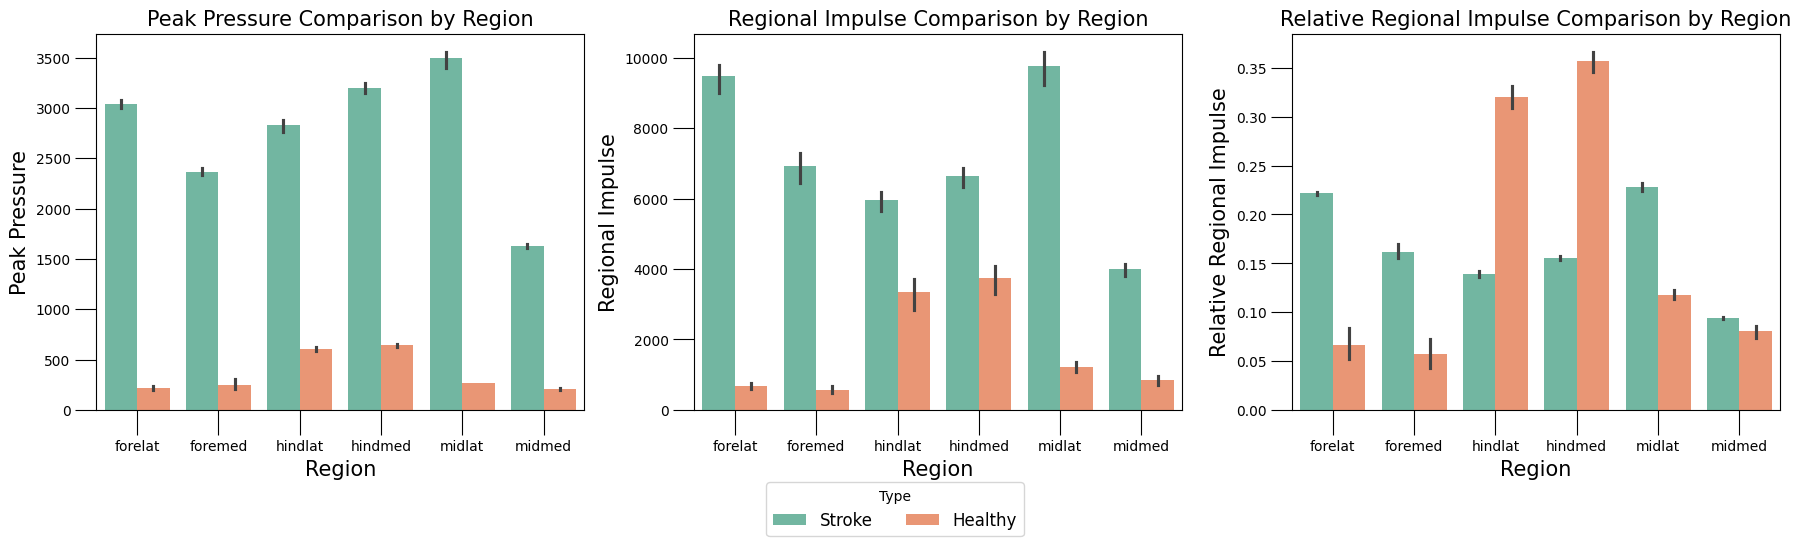

In [14]:
# Define the metrics to visualize
metrics = ["Peak Pressure", "Regional Impulse", "Relative Regional Impulse"]

# Set the figure size
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Iterate through each metric and create a bar plot
for ax, metric in zip(axes, metrics):
    sns.barplot(
        data=final_output_df,
        x="Region",
        y=metric,
        hue="type",
        ax=ax,
        palette="Set2"
    )
    ax.set_title(f"{metric} Comparison by Region",fontsize = 15)
    ax.legend(title="Type", fontsize=15)
    ax.set_xlabel("Region",fontsize = 15)
    ax.set_ylabel(metric,fontsize = 15)
    ax.tick_params(axis='y', rotation=0,size = 15)
    ax.tick_params(axis='x', rotation=0,size = 18)
    
for ax in axes:
    ax.legend_.remove()

# Add a single legend to the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Type", fontsize=12, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# Adjust layout for better readability
plt.tight_layout()
plt.show()
fig.savefig('figure/stroke_normal_comparison.png', bbox_inches='tight', dpi=600)  # Save the figure

In [ ]:
# Remove individual legends
for ax in axes:
    ax.legend_.remove()

# Add a single legend to the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Type", fontsize=12, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# Adjust layout for better readability
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent visual style
sns.set(style="whitegrid")

# Define the metrics to visualize
metrics = ["Peak Pressure", "Regional Impulse", "Relative Regional Impulse"]

# Create subplots for each metric
fig, axes = plt.subplots(nrows=3, figsize=(12, 15))

# Plot boxplots for each metric grouped by Region and differentiated by type (Normal/Stroke)
for ax, metric in zip(axes, metrics):
    sns.boxplot(
        data=df,
        x="Region",
        y=metric,
        hue="type",
        ax=ax
    )
    ax.set_title(f"{metric} Comparison by Region")
    ax.set_xlabel("Region")
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

C:\Users\jackz\AppData\Local\Temp\ipykernel_37472\2940904821.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='GroupRegion', y='Peak Pressure', order=x_order, palette=colors, ax=axes[0])
C:\Users\jackz\AppData\Local\Temp\ipykernel_37472\2940904821.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='GroupRegion', y='Regional Impulse', order=x_order, palette=colors, ax=axes[1])
C:\Users\jackz\AppData\Local\Temp\ipykernel_37472\2940904821.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='GroupRegion', 

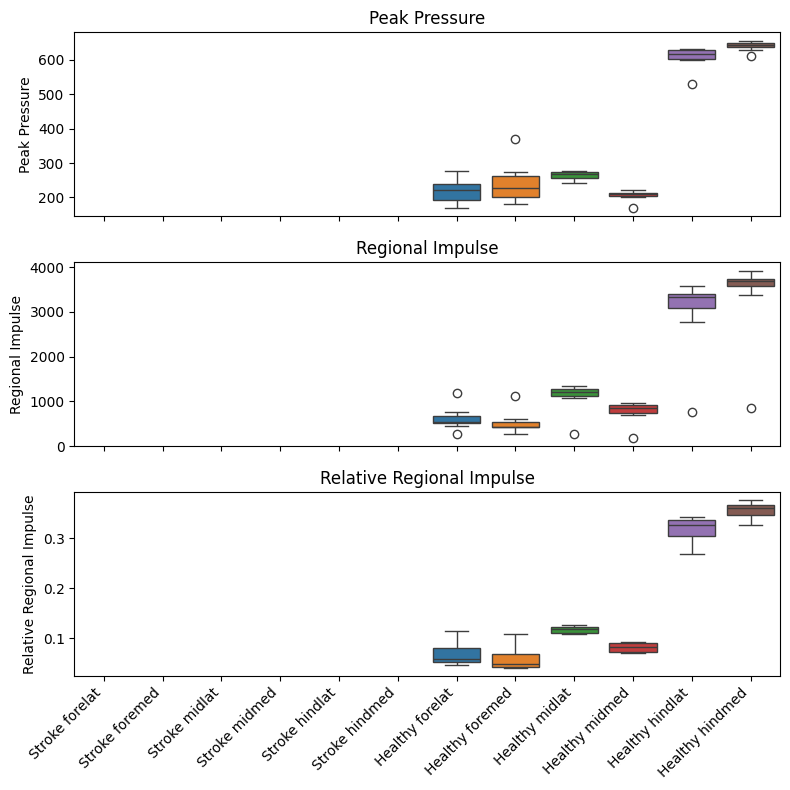

In [ ]:
df = final_output_df

# Define the order of categories for the x-axis
region_order = ['forelat', 'foremed', 'midlat', 'midmed', 'hindlat', 'hindmed']
x_order = [f"Stroke {r}" for r in region_order] + [f"Healthy {r}" for r in region_order]

# Create a new column for group-region combination
df['GroupRegion'] = df['type'] + ' ' + df['Region']

region_palette = {
    'forelat': '#1f77b4',  # blue
    'foremed': '#ff7f0e',  # orange
    'midlat': '#2ca02c',   # green
    'midmed': '#d62728',   # red
    'hindlat': '#9467bd',  # purple
    'hindmed': '#8c564b'   # brown
}

# Create a color list for the x-axis categories
colors = [region_palette[region] for region in region_order] * 2  # repeat for Stroke and Normal

# Set up the figure and subplots again
fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

# Plot each boxplot with custom colors
sns.boxplot(data=df, x='GroupRegion', y='Peak Pressure', order=x_order, palette=colors, ax=axes[0])
axes[0].set_title('Peak Pressure')
axes[0].set_ylabel('Peak Pressure')

sns.boxplot(data=df, x='GroupRegion', y='Regional Impulse', order=x_order, palette=colors, ax=axes[1])
axes[1].set_title('Regional Impulse')
axes[1].set_ylabel('Regional Impulse')


sns.boxplot(data=df, x='GroupRegion', y='Relative Regional Impulse', order=x_order, palette=colors, ax=axes[2])
axes[2].set_title('Relative Regional Impulse')
axes[2].set_ylabel('Relative Regional Impulse')
axes[2].set_xlabel('')

# Set xticks and labels for all subplots
for ax in axes:
    ax.set_xticks(range(len(x_order)))
    ax.set_xticklabels(x_order, rotation=45, ha='right', size = 10)

plt.tight_layout()
plt.show()

In [ ]:
final_output_df

,Region,Peak Pressure,Regional Impulse,Relative Regional Impulse,sample_idx,foot,type,GroupRegion
0,forelat,233.062857,758.528214,0.073330,0,right,Healthy,Healthy forelat
1,foremed,221.313063,600.004595,0.058005,0,right,Healthy,Healthy foremed
2,hindlat,600.734553,3181.889350,0.307604,0,right,Healthy,Healthy hindlat
3,hindmed,655.991818,3741.347203,0.361689,0,right,Healthy,Healthy hindmed
4,midlat,264.157014,1219.591081,0.117902,0,right,Healthy,Healthy midlat
5,midmed,211.829889,842.732162,0.081470,0,right,Healthy,Healthy midmed
6,forelat,211.798333,643.094133,0.061131,1,right,Healthy,Healthy forelat
7,foremed,234.439614,522.716739,0.049688,1,right,Healthy,Healthy foremed
8,hindlat,601.756440,3333.651311,0.316887,1,right,Healthy,Healthy hindlat
9,hindmed,639.288931,3725.698659,0.354154,1,right,Healthy,Healthy hindmed


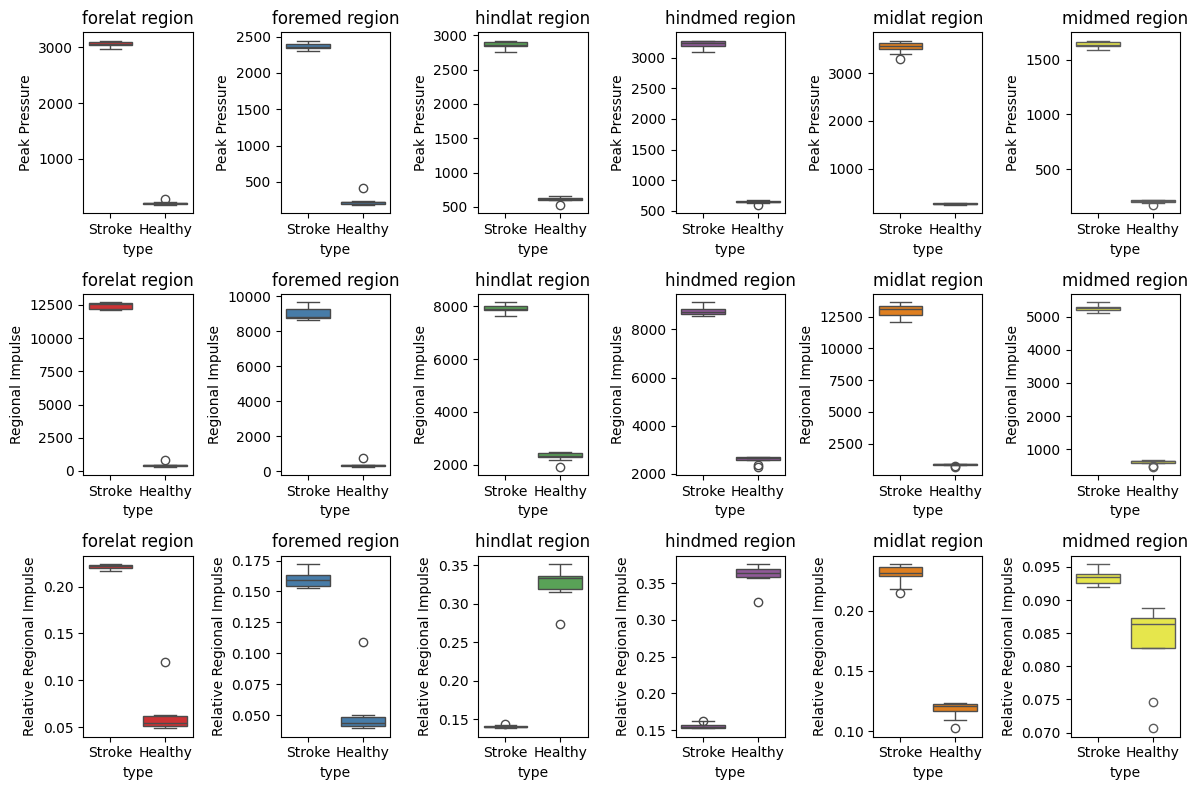

In [ ]:
df = final_output_df
variables = ["Peak Pressure", "Regional Impulse", "Relative Regional Impulse"]
region_indices = sorted(df["Region"].dropna().unique())
palette = dict(zip(range(6), sns.color_palette("Set1", len(region_indices))))  # Using 'viridis' colormap


# Create subplots with 3 rows (variables) and 5 columns (region indices)
fig, axes = plt.subplots(len(variables), len(region_indices), figsize=(12, 8))

# Generate box plots
for j, var in enumerate(variables):
    for i, region in enumerate(region_indices):
        ax = axes[j, i]
        sns.boxplot(
            data=df[df["Region"] == region],
            x="type",
            y=var,
            ax=ax,
            color=palette[i]
        )
        ax.set_title(f"{region} region")
        # ax.set_xlabel("Foot")
        ax.set_ylabel(var)

# Adjust layout for readability
plt.tight_layout()
plt.show()

In [ ]:
region_indices

['forelat_left',
 'forelat_right',
 'foremed_left',
 'foremed_right',
 'hindlat_left',
 'hindlat_right',
 'hindmed_left',
 'hindmed_right',
 'midlat_left',
 'midlat_right',
 'midmed_left',
 'midmed_right']

In [ ]:
region_indices

['forelat_left',
 'forelat_right',
 'foremed_left',
 'foremed_right',
 'hindlat_left',
 'hindlat_right',
 'hindmed_left',
 'hindmed_right',
 'midlat_left',
 'midlat_right',
 'midmed_left',
 'midmed_right']